In [22]:
# Import Libraries and Basic Setup
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix,
    RocCurveDisplay, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import joblib
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

print("Libraries imported successfully")


Libraries imported successfully


In [23]:
# Configuration Parameters
RANDOM_STATE = 42
TEST_SIZE = 0.2
KFOLDS = 5
MODEL_PATH = "breast_cancer_logistic.pkl"
SCALER_PATH = "breast_cancer_scaler.pkl"

print("Configuration set:")
print(f"Random State: {RANDOM_STATE}")
print(f"Test Size: {TEST_SIZE}")
print(f"K-Folds: {KFOLDS}")


Configuration set:
Random State: 42
Test Size: 0.2
K-Folds: 5


In [24]:
# Load and Explore Dataset
def load_breast_cancer_data():
    """Load and display basic info about breast cancer dataset"""
    data = load_breast_cancer(as_frame=True)
    X = data.data
    y = data.target
    feature_names = data.feature_names
    target_names = data.target_names
    
    print("Dataset loaded successfully")
    print(f"Shape: {X.shape}")
    print(f"Features: {len(feature_names)}")
    print(f"Classes: {list(target_names)}")
    print(f"Class distribution: Malignant={np.sum(y==0)}, Benign={np.sum(y==1)}")
    
    return X, y, feature_names, target_names

# Load data
X, y, feature_names, target_names = load_breast_cancer_data()


Dataset loaded successfully
Shape: (569, 30)
Features: 30
Classes: ['malignant', 'benign']
Class distribution: Malignant=212, Benign=357


In [25]:
# Data Preprocessing
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Data preprocessing completed
Training set: 455 samples
Test set: 114 samples


In [ ]:
# Model Training with Grid Search
print("Training model with grid search...")

# Simplified parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'max_iter': [1000]
}

# Grid search
lr = LogisticRegression(random_state=RANDOM_STATE)
grid_search = GridSearchCV(lr, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV AUC: {grid_search.best_score_:.4f}")


Training model with grid search...
Best parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV AUC: 0.9944


In [27]:
# Test Set Evaluation
# Make predictions
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_prob)

print("Test Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"AUC: {test_auc:.4f}")


Test Set Performance:
Accuracy: 0.9825
Precision: 0.9861
Recall: 0.9861
F1-Score: 0.9861
AUC: 0.9960


In [28]:
# Save Model and Scaler
joblib.dump(best_model, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
print(f"Model saved to: {MODEL_PATH}")
print(f"Scaler saved to: {SCALER_PATH}")


Model saved to: breast_cancer_logistic.pkl
Scaler saved to: breast_cancer_scaler.pkl


In [29]:
# 5-Fold Cross Validation
print("Starting 5-Fold Cross Validation...")
print("-" * 40)

# Set up cross validation
skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=RANDOM_STATE)

# Store metrics for each fold
cv_results = []

# Simple logistic regression for CV
cv_model = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', 
                             max_iter=1000, random_state=RANDOM_STATE)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    # Split data for this fold
    X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
    y_fold_train, y_fold_val = y[train_idx], y[val_idx]
    
    # Standardize
    fold_scaler = StandardScaler()
    X_fold_train_scaled = fold_scaler.fit_transform(X_fold_train)
    X_fold_val_scaled = fold_scaler.transform(X_fold_val)
    
    # Train and predict
    cv_model.fit(X_fold_train_scaled, y_fold_train)
    val_pred = cv_model.predict(X_fold_val_scaled)
    val_prob = cv_model.predict_proba(X_fold_val_scaled)[:, 1]
    
    # Calculate metrics
    fold_accuracy = accuracy_score(y_fold_val, val_pred)
    fold_f1 = f1_score(y_fold_val, val_pred)
    fold_auc = roc_auc_score(y_fold_val, val_prob)
    
    cv_results.append({
        'fold': fold,
        'accuracy': fold_accuracy,
        'f1': fold_f1,
        'auc': fold_auc
    })
    
    print(f"Fold {fold} - AUC: {fold_auc:.4f}, Accuracy: {fold_accuracy:.4f}, F1: {fold_f1:.4f}")

print("-" * 40)


Starting 5-Fold Cross Validation...
----------------------------------------
Fold 1 - AUC: 0.9954, Accuracy: 0.9737, F1: 0.9787
Fold 2 - AUC: 0.9977, Accuracy: 0.9561, F1: 0.9660
Fold 3 - AUC: 0.9851, Accuracy: 0.9649, F1: 0.9730
Fold 4 - AUC: 1.0000, Accuracy: 0.9912, F1: 0.9930
Fold 5 - AUC: 0.9987, Accuracy: 0.9912, F1: 0.9930
----------------------------------------


<Figure size 800x600 with 0 Axes>

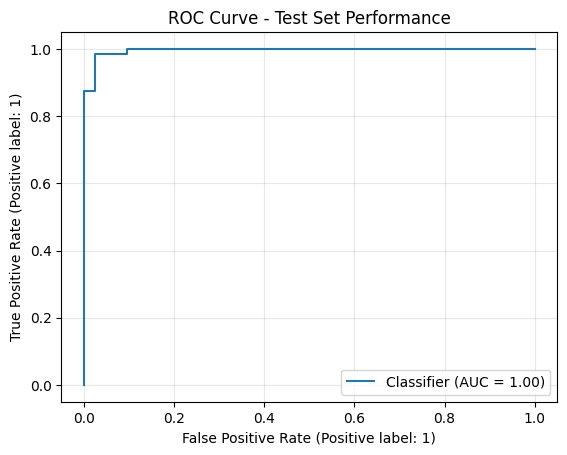

ROC AUC Score: 0.9960


In [30]:
# ROC Curve Visualization
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title('ROC Curve - Test Set Performance')
plt.grid(True, alpha=0.3)
plt.show()

print(f"ROC AUC Score: {test_auc:.4f}")


<Figure size 600x500 with 0 Axes>

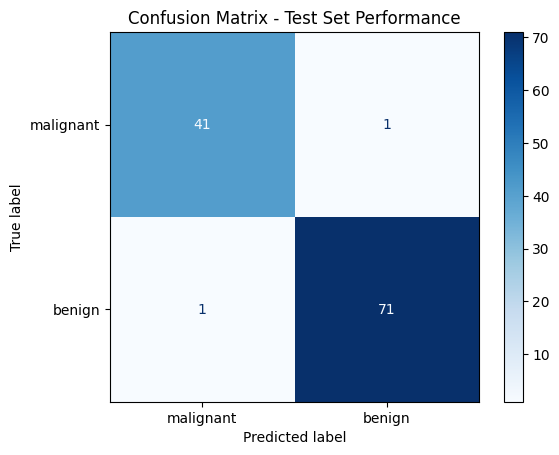

Detailed Classification Report:
----------------------------------------
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [31]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=target_names, cmap='Blues'
)
plt.title('Confusion Matrix - Test Set Performance')
plt.show()

# Print detailed classification report
print("Detailed Classification Report:")
print("-" * 40)
print(classification_report(y_test, y_pred, target_names=target_names))


In [32]:
# Cross Validation Summary
cv_df = pd.DataFrame(cv_results)

print("Cross Validation Summary:")
print("-" * 30)
print(f"Accuracy: {cv_df['accuracy'].mean():.4f} ± {cv_df['accuracy'].std():.4f}")
print(f"F1-Score: {cv_df['f1'].mean():.4f} ± {cv_df['f1'].std():.4f}")
print(f"AUC: {cv_df['auc'].mean():.4f} ± {cv_df['auc'].std():.4f}")


Cross Validation Summary:
------------------------------
Accuracy: 0.9754 ± 0.0157
F1-Score: 0.9807 ± 0.0121
AUC: 0.9954 ± 0.0060


In [33]:
# Feature Importance Analysis
feature_importance = np.abs(best_model.coef_[0])
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print("-" * 35)
for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
    print(f"{i:2}. {row['feature']}: {row['importance']:.4f}")


Top 10 Most Important Features:
-----------------------------------
 1. worst texture: 0.5486
 2. worst radius: 0.5156
 3. worst concave points: 0.4968
 4. worst area: 0.4957
 5. worst perimeter: 0.4728
 6. radius error: 0.4590
 7. mean texture: 0.4280
 8. mean concave points: 0.4138
 9. area error: 0.4099
10. worst symmetry: 0.4055


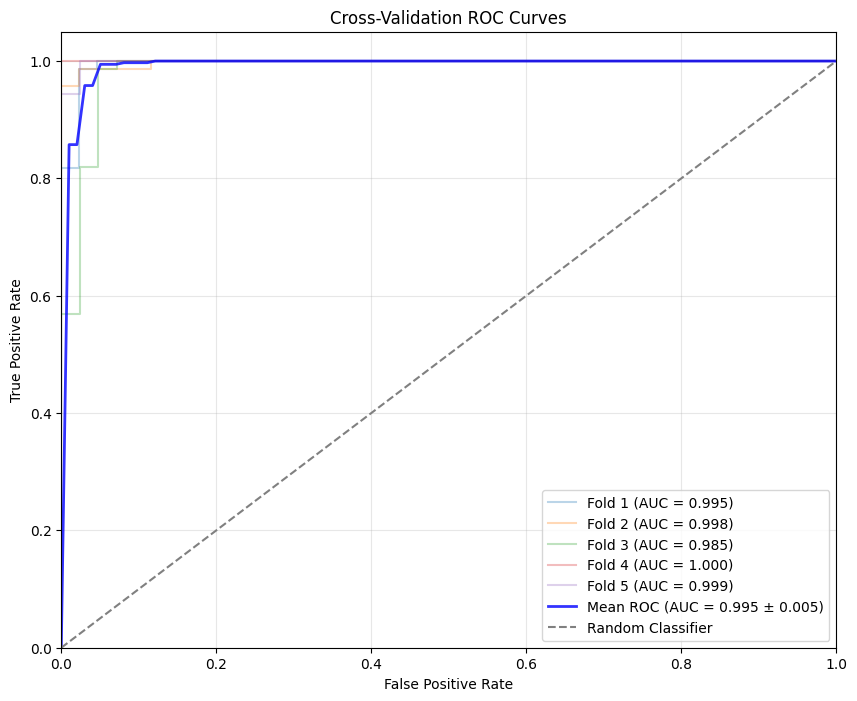

In [34]:
# Cross-Validation ROC Curves
from sklearn.metrics import roc_curve
from scipy import interp

plt.figure(figsize=(10, 8))

# Store ROC curves for each fold
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Plot ROC curve for each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    # Split data for this fold
    X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
    y_fold_train, y_fold_val = y[train_idx], y[val_idx]
    
    # Standardize
    fold_scaler = StandardScaler()
    X_fold_train_scaled = fold_scaler.fit_transform(X_fold_train)
    X_fold_val_scaled = fold_scaler.transform(X_fold_val)
    
    # Train and predict
    cv_model.fit(X_fold_train_scaled, y_fold_train)
    val_prob = cv_model.predict_proba(X_fold_val_scaled)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_fold_val, val_prob)
    interp_tpr = interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    roc_auc = roc_auc_score(y_fold_val, val_prob)
    aucs.append(roc_auc)
    
    plt.plot(fpr, tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.3f})')

# Plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='b', 
         label=f'Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})',
         lw=2, alpha=0.8)

# Plot random classifier line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-Validation ROC Curves')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


In [35]:
# Model Analysis Summary
print("Model Analysis Summary:")
print("-" * 25)

mean_cv_auc = cv_df['auc'].mean()
if mean_cv_auc > 0.95:
    performance_level = "Excellent"
elif mean_cv_auc > 0.90:
    performance_level = "Good"
else:
    performance_level = "Fair"

print(f"Performance Level: {performance_level}")
print(f"Average CV AUC: {mean_cv_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Model Stability: {'High' if cv_df['auc'].std() < 0.02 else 'Moderate'}")

print("\nAnalysis Complete!")


Model Analysis Summary:
-------------------------
Performance Level: Excellent
Average CV AUC: 0.9954
Test AUC: 0.9960
Model Stability: High

Analysis Complete!


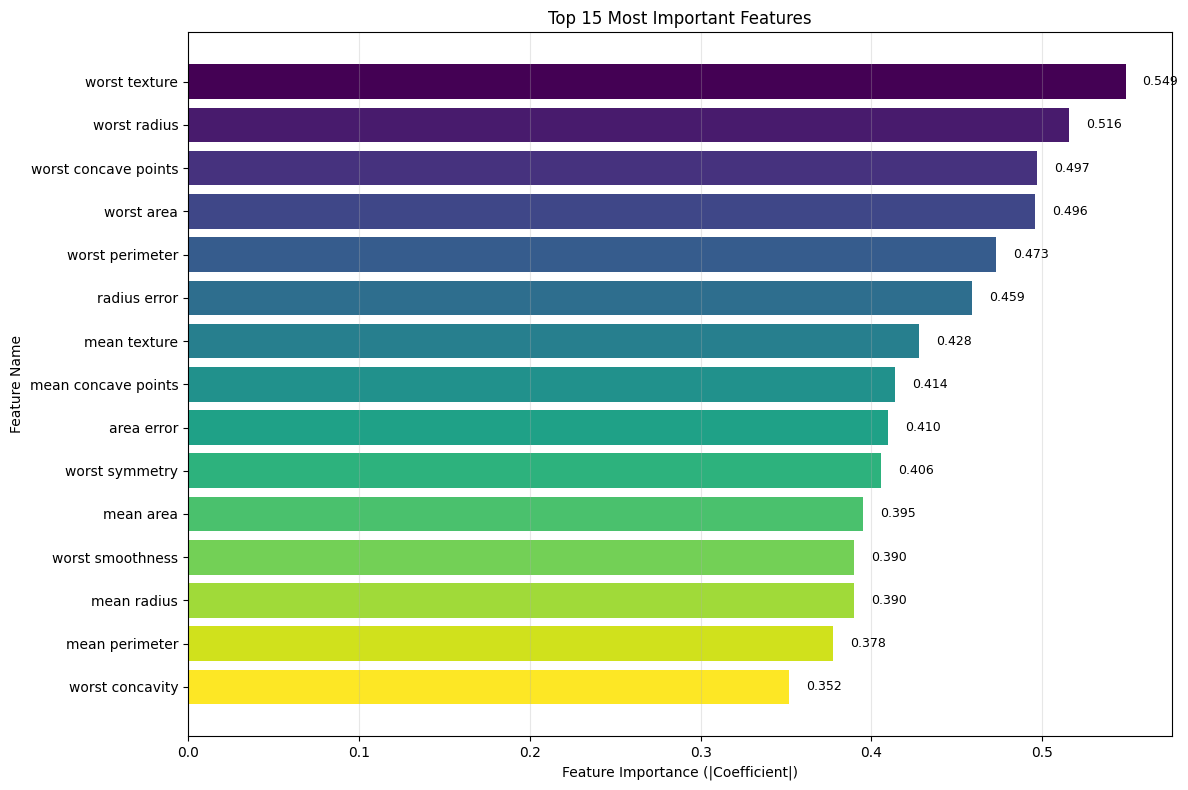

In [36]:
# Feature Importance Visualization
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)

# Create horizontal bar plot
bars = plt.barh(range(len(top_features)), top_features['importance'], 
               color=plt.cm.viridis(np.linspace(0, 1, len(top_features))))

plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (|Coefficient|)')
plt.ylabel('Feature Name')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()  # Highest importance at top

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, top_features['importance'])):
    plt.text(value + 0.01, i, f'{value:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.grid(True, alpha=0.3, axis='x')
plt.show()
